# Ordinary Differential Equation Solver "Odie:" a C Code

## Authors: Gabriel M Steward

### January 2023

https://github.com/zachetienne/nrpytutorial/blob/master/Tutorial-Template_Style_Guide.ipynb

Link to the Style Guide. Not internal in case something breaks. 

### </list_source_code> NRPy+ Source Code for this module:
Butcher Tables, eventually.

## Introduction:
This Ordinary Differential Equation Solver, affectionately known as "Odie," takes a single Ordinary Differential Equation (ODE) with a boundary condition and solves it Numerically, the result being a text file with the previously unknown function's values. The code is generic and can use any Runge Kutta-style method to solve the ODE. That said, the methods currently have to be inserted manually in a format known as a "butcher table." The following methods are included by default: the first-order Euler's Method, Runge Kutta 2 for second-order, Runge Kutta 3 (strong stability preserving, or SSPRK3) for third-order, Runge Kutta 4 (the standard one) for fourth-order, and Runge Kutta 5 (Cash-Karp version) for fifth-order. In addition, the program supports an internal validation check which checks the order of the error.

Note that while this program does solve ODEs, it currently assumes that the ODE it is solving is already known and continually compares its results to the truth to check for error. For an unknown result, the code would have to be altered slightly to not continually calculate errors. 

This is just the very beginnings of the code. It will be expanded to systems of ODEs and gain variable time-step functionality eventually. 

The user cannot specify anything on runtime. If the function, solution method, step size, or boundary condition needs to be changed it must be done manually. 

## </other>  Other:
A note: this notebook is not suitable as a tutorial yet, it is simply an explanation. When the project is finished, however, it should serve as a tutorial. 

### Note on Notation:
Any new notation will be brought up in the notebook when it becomes relevant. 

### Citations:

Matplotlib documentation. (Needs no citation?) 

<a id='1'></a>
[1] https://en.wikibooks.org/wiki/C_Programming/time.h (Using time.h)

<a id='2'></a>
[2] https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h (math.h compilation requirements)

<a id='3'></a>
[3] https://www.tutorialspoint.com/cprogramming/c_file_io.htm (Basic file operations)

<a id='4'></a>
[4] Numerical Mathematics and Computing 6E by Cheney and Kincaid (Primary Text)

<a id='5'></a>
[5] NRPy+ "Solving the Scalar Wave Equation" (Plotting code, surprisingly)

<a id='6'></a>
[6] https://www.dataquest.io/blog/read-file-python/ (Opening and reading CSV files)

<a id='7'></a>
[7] https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib (Changing size of plot)

New One for the New Code...

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

1. [Step 1:](#S1) Background: The Problem Statement

    2. [Step 1a:](#S1a) Validation Method

3. [Step 2:](#S2) The Code

    4. [Step 2a:](#S2a) C-Code

    5. [Step 2b:](#S2b) Results
    
6. [Step 3:](#S3) Analysis

7. [Step 4:](#S4) Conclusion

7. [Step 5:](#S5) Output this notebook to $\LaTeX$-formatted PDF file

<a id='S1'></a>

# Step 1: Background: The Problem Statement \[Back to [top](#toc)\]
$$\label{S1}$$

### In order to solve a problem, one must first know the problem exists.

This program seeks to take an Ordinary Differential Equation and solve it. To be clear, an Ordinary Differential Equation is an equation relating a function and its derivatives together, with the requirement that all derivatives be taken with respect to a single variable. If multiple variable derivatives are involved, it becoems a Partial Differential Equation. Currently, this program is also limited to only handling first-order Ordinary Differential Equations with only first derivatives in it, though this will later be expanded.

Mathematically, our solver can solve equations of the form:

$$ \frac{dy(x)}{dx} = f(x,y(x)) ; \text{ given } y(a)=b$$

Where f is some function that does not contain any derivative or integral operators. A solution is to find what the function y(x) actually is. The given y(a)=b is the boundary condition for this problem. For this solver we start at the point a and increase it over time, treating it as an "initial condition." 

The program will restrict itself to Runge-Kutta type solution methods, which take an initial condition and evolve it forward in "time" with various relational methods, all of which are based in the Taylor Series Expansion. The specifics of these methods can be found elsewehre ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)). The basic idea is that one value is used to calculate another value forward in "time," and this new value can be used to find the next one, and so on and so forth. Since we start with an initial condition, we can always use that. 

Of note: the problem can be solved with no information as to what y actually is. However, since this program is currently in its early stages, we are only using simple equations will very well known answers, so we make use of this and continuously compare the program's calculated result with the real one to see how our errors behave. 

<a id='S1a'></a>

# Step 1a: Validation Method \[Back to [top](#toc)\]
$$\label{S1a}$$

### A program is worse than useless if it doesn't work and you don't know it.

An important part of simulation codes is validation--does the program do what we expect it to do when presented with known data? Since we have the solutions to the simple equations we are testing already present, we have an opportunity to see not only if our estimations are accurate, but also if the error terms behave as expected. Every method we use has an associated "error term" with it, $\mathcal{O}(h^m)$ where m is some integer that indicates the order of the error term. A first-order method would have m=2 since the method accurately represents terms up to m=1, and then the error is m=2. In words, a method of a certain order gets everything right up to that order, but not beyond it.

At the moment we are concerned with the error with respect to the step size, which is how far in "time" we evolve the solution with every calculation. The question is, how exactly do we determine the order of a method from the data alone? If the order of error matches what we expect, we consider the method validated. 

To start, we can extract the error with the rather simple relation 

$$ \text{Truth} - \text{Calculation} = \text{Error} = \mathcal O(h^m) $$

Now, O-notation is somewhat ambiguous, for we do not know how large the term it represents is, and there can be terms of order higher than m that are supressed. If we assume that the m-order term dominates all the others, then we can write out

$$ E = Ah^m,$$

where E is error, A is some unknown constant, h is the step size, and m is the order. 

Let us say that we were to perform this error calculation twice: once for some unknown step value h, and once for precisely half, h/2. This would produce two different error values. 

$$ E_1 = Ah^m; E_2 = A \frac{h^m}{2^m}$$

We can solve both of these equaitons for A, which is the same in both.

$$ A = \frac{E_2}{h^m / 2^m} = \frac{E_1}{h^m} $$

From here we can just solve for m.

$$ \Rightarrow \frac{E_2}{E_1} = \frac{1}{2^m} $$
$$ \Rightarrow \frac{E_1}{E_2} = 2^m $$
$$ \Rightarrow m = log_2 \frac{E_1}{E_2} $$

Keep in mind that m is the order of the error term, the actual order of the method used would be m-1 in this case. So a first-order method would have m=2. Also be careful to keep the "1" and "2" subscripts on the errors in the right sequence, the "2" comes from the halved step size. 

This method is very convenient for a few reasons. For one, it doesn't require any Taylor Series terms or any inputs aside from the first error terms of two separate calculations. In addition, the errors should be taken from the *first* step which means it isn't necessary to perform the calculations for the entire ODE twice just to get an order estimate. 

It does have a rather major failing though, and that comes with its primary assumption: that the errors are dominated by a single term. This need not be the case and often changes based on the step size. The other higher-order error terms do influence the result, and they can do it in unexpected ways, and as such the result "m" will rarely, if ever, actually be an integer. However, as we know it should be an integer, if we round all the problems from the other terms will usually go away, though not always. Fortuantely, as this validation is largely for the method itself and not the answer, it's always possible to just insert a different more well-behaved function for validation. We use one of these funcitons in the below code to make everything neat. 

There is a quirk that occurs if the Taylor Series Expansion of a solution is missing terms (or is finite). Say, for instance, the m=3 term was missing and we had an order 2 solver. Well, the order detector expects to find m=3, but instead it finds m=4 since there isn't any m=3 error term to find. This is not a problem, it is perfectly fine for a method to have an order *higher* than expected. Lower is when there would be a problem. Similar issues occur if the soluiton is exact or near exact, in which case the validation will claim the error order is infinite. 

Now that we have our tools, we are prepared to look at the actual program. 

<a id='S2'></a>

# Step 2: The Code \[Back to [top](#toc)\]
$$\label{S2}$$

### Odie is our friend, but do we understand our friend?

Before looking at the code itself, lets first discuss how it operates. Before running the code, it is important that the user manually set certain things in the code itself. Within the funciton `diffyQEval` lies the definition of the differential equation itself. For this notebook, we have y' = y + 1 as our declaration, written as `return y+1.0;`. Any funciton of y and x can be placed here, as the funciton is passed x and y variables when called. In this case the passed x variable does nothing, but the functionality exists. 

In the function `knownQEval` we have the known solution. In this case it is $e^x-1$ represented by `return exp(x)-1.0;`. This is not strictly needed, as the program can find the solution on its own, but as we are very concerned with errors we want a truth to continually check against. 

The boundary condition needs to be declared as well. The variables for them are in the main function, with `bound` being the location of the boundary, and `bValue` being the value *at* that point. It's best to think of x as being `bound` and y as being `bValue`. For our ODE both of these are set to zero. 

Lastly, there are a set of mutable parameters that determine how the simulation is run. `step` is the step size, which we have set to 0.01 for these tests. Smaller numbers mean better accuracy here. `SIZE` is how large the area we're solving for is. We start at `bound` but `SIZE` determined where we end. Normally this number should be quite large, but we have it set to 10 so we can print out all the results for this notebook. Lastly, there is a boolean variable `validate` which should be set to true if validation is desired, and false if not. We naturally have it set to true here. 

On runtime, the user is not given a chance to specify these numbers, as they are coded in. The user *is* given the opportunity to choose which method is executed. Three are installed by default: Euler's first-order method, the second-order Runge-Kutta method, and the fourth-order Runge-Kutta method, selected by typing 1, 2, and 4 respectively. The RK4 method is one commmonly used across multiple solvers. 

After the method is chosen, the code activates, sets up a timer to let you know how many seconds the operation took, and opens a file to write all the output to. After that it executes the chosen method, the specifics of which we shall not go into since they are described elsewhere ([here](https://nbviewer.org/github/zachetienne/nrpytutorial/blob/master/Tutorial-RK_Butcher_Table_Dictionary.ipynb)). What should be noted is that on the first step, if `validation` is set to true, the code will attempt to evaluate the order of the error. It will always spit out something (even if that something is N/A or infinity), but it also checks to see if the error is currently within roundoff error (about 1e-14) for double precision variables. If it determines that it is within that error, it will attempt to calculate the order of the error again next step. Once it is past this, however, it will stop calculating and let the code run without any more validation. This is most helpful for calculations that start out *very* accurate but over time drift away. That said, this will compound the error in the order calculation itself, so the longer it takes for the system to reach a point outside of roundoff error the less the number should be trusted. We are unsure of precisely how much. 

With the calculation complete, the program closes the file it was writing to, `oData.txt`, reports the time taken in seconds, and ends. 

<a id='S2a'></a>

# Step 2a: C-Code \[Back to [top](#toc)\]
$$\label{S2a}$$

### Behold, the solver. 

Below is the C-Code. Numerous output lines are commented out and can be un-commented at will if a user wishes to examine in more detail what's happening during runtime. Code is heavily commented, some of it is likely redundant with the section above, but looking at things two different ways rarely hurts. 

```
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <stdbool.h>
#include <time.h> //we like to know how long things take. 
//having not used time.h before we refered to
//https://en.wikibooks.org/wiki/C_Programming/time.h

//Note: math.h requries the "-lm" arg be added at the END of tasks.json's arguments.
//https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

//ODE Solver
//By G. M. Steward
//The main goal of this project is to solve Ordinary Differential Equation Systems
//in complete generality. However, we will take a while to get there.
//This third version, V3, is mainly concerned with validations.
//As well as comment cleanup. 
//Very munimal user functionality, will need to be revamped. 
//Taylor Series Validation Method was removed since it was not appropriate for this context. 

//Heavily influenced by Numerical Mathematics and Computing 6E by Cheney and Kincaid.

//Outside the program, we substantiate the differential equation itself.
double diffyQEval (double x, double y)
{
    return y+1.0;
    //This is the differential equation itself. 
    //"return y" is the most basic result, for a basic exponential diffyQ.
    //feel free to change the return value to other functions. 
    //Note: not guaranteed to work for functions that are not well-behaved. 
}

//This is the function to evaluate the known solution. Must be set manually.
double knownQEval (double x)
{
    return exp(x)-1.0;
    //the known solution to the differential equaiton. 
    //used to measure relative errors. 
    //exp(x) is "default."
}

//Remember when adjusting these to adjust the boundary value bValue as well. 

int main()
{
    printf("Beginning ODE Solver \"Odie\" V1...\n");
    
    //SECTION I: Preliminaries
    //Before the program actually starts, variables need to be created
    //and set, as well as the function itself chosen. 
    //The diffyQ itself can be found declared in diffyQEval().
    double step = 0.01; //the "step" value. 
    double bound = 0.0; //where the boundary/initial condition is.
    //Should work with non-integer boundaries.

    double bValue = 0.0; //the value at y(bound). 
    //by default we say y(0) = 1. 
    const int SIZE = 10; //How many steps we are going to take. 
    bool validate = true; //set to true if you wish to run a validation test.
    //Attempts to find the order of the method used. 

    int method = 1; //sets the method. 1 is Euler's Method, 2 is Runge-Kutta Order 2. 4 is RK4
    //very basic user interface for method selection.
    printf("Which method to use? 1: Euler, 2: RK2, 4: RK4\n");
    scanf("%d", &method);
    printf("Using Method %d\n", method);


    double y1;
    double y2;
    double yTruth1;
    double yTruth2;
    double yError;
    //These variables temporarily store the values calculated before they are 
    //printed to the output file and forgotten. 
    //y is what we solve for, yTruth is the "known results."
    //yError is the error of y when compared to yTruth
    //Should be able to handle any size, unlike arrays, which just hog memory. 

    y1 = bValue; //boundary condition, have to start somewhere.
    yTruth1 = knownQEval(bound);
    yError = 0; //has to be zero as they must match at this point.

    double saveErr1=0, saveErr2=0; //variables for validation if requested. 
    
    //SECTION II: The Loop
    //prior to beginning the loop, start the timer. 

    double startN = time(NULL);
    //printf("Time: %.90f seconds\n", startN);
    //set start time to current time. Printing disabled.

    //also open the file we'll be writing data to. 
    FILE *fp;
    fp = fopen("oData.txt","w");

    //This loop fills out all the data. 
    //The switch is here to decide which method to use. 
    printf("INITIAL: Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound,yTruth1, y1, yError);
    fprintf(fp,"Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound,yTruth1, y1, yError);
    switch(method) {
        case 1: {
            for (int i = 0; i < SIZE; i++){
        
                y2 = y1 + step*diffyQEval(bound+i*step,y1);
                //This is Euler's method. 
                //Very basic, uses information on derivatives and functions
                //to calculate the function itself step by step.
        
                yTruth2 = knownQEval(bound+step*(i+1));
                yError = (yTruth2 - y2);

                //After each step is calculated, print results. 
                //printf("Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);
                //uncomment if you want live updates. 
                fprintf(fp,"Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);
                
                //validation: grab the first nonzero error, calculate its order.
                if(validate==true && sqrt(saveErr1*saveErr1) <= 0.000000000000001) {
                    //tiny but nonzero number allows us to avoid roundoff error. 
                    saveErr1 = yError;

                    //The following is an algorithm for determining the rate of error 
                    //convergence. A bit rudimentary, could be condensed, but is also only
                    //called once so not relaly a concern and it is easier to read this way. 
                    double yValidate = y1 + step*0.5*diffyQEval(bound+i*step*0.5,y1);
                    double truthValidate = knownQEval(bound+step*0.5);
                    saveErr2 = (truthValidate - yValidate);
                    //Basically we just calculated the initial error for half step size. 
                    //Now we can compare using the equation for order estimation:
                    double order =  log2(saveErr1/saveErr2);
                    printf("Order of Error: %f\n", order);
                }

                y1=y2;
                yTruth1=yTruth2;

            }
            break;
            //Remember to use break or else switch keeps going. 
        }
        case 2: {
            double K1, K2; //The varabiles that store our Runge-Kutta results. 
            for (int i = 0; i < SIZE; i++){
                
                K1 = step*diffyQEval(bound+i*step,y1);
                K2 = step*diffyQEval(bound+i*step+step,y1 + K1);
                y2 = y1 + 0.5*(K1+K2);
                //This is the Runge-Kutta 2 method.  
                //Should have second-order error. 
        
                yTruth2 = knownQEval(bound+step*(i+1));
                yError = (yTruth2 - y2);

                //After each step is calculated, print results. 
                //printf("Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);
                //uncomment if you want live updates. 
                fprintf(fp,"Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);

                //validation: grab the first nonzero error, calculate its order.
                if(validate==true && sqrt(saveErr1*saveErr1) <= 0.000000000000001) {
                    //tiny but nonzero number allows us to avoid roundoff error. 
                    saveErr1 = yError;

                    //The following is an algorithm for determining the rate of error 
                    //convergence. A bit rudimentary, could be condensed, but is also only
                    //called once so not relaly a concern and it is easier to read this way.
                    K1 = step*0.5*diffyQEval(bound+i*step,y1);
                    K2 = step*0.5*diffyQEval(bound+i*step*0.5+step*0.5,y1 + K1);
                    double yValidate = y1 + 0.5*(K1+K2);
                    double truthValidate = knownQEval(bound+step*0.5);
                    saveErr2 = (truthValidate - yValidate);
                    //Basically we just calculated the initial error for half step size. 
                    //Now we can compare using the equation for order estimation:
                    double order =  log2(saveErr1/saveErr2);
                    printf("Order of Error: %f\n", order);
                }

                y1=y2;
                yTruth1=yTruth2;

            }
            break;
        }
        case 4: {
            double K1, K2, K3, K4; //The varabiles that store our Runge-Kutta results. 
            for (int i = 0; i < SIZE; i++){
                
                K1 = step*diffyQEval(bound+i*step,y1);
                K2 = step*diffyQEval(bound+i*step+0.5*step,y1 + K1*0.5);
                K3 = step*diffyQEval(bound+i*step+0.5*step,y1 + K2*0.5);
                K4 = step*diffyQEval(bound+i*step+step,y1 + K3);
                y2 = y1 + (1.0/6.0)*(K1+2.0*K2 + 2.0*K3 + K4);
                //This is the Runge-Kutta 4 method.  
                //Should have fourth-order error. 
                //Regularly gives answers reasonably accurate up to rounding error! 

                yTruth2 = knownQEval(bound+step*(i+1));
                yError = (yTruth2 - y2);

                //After each step is calculated, print results. 
                //printf("Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);
                //uncomment if you want live updates. 
                fprintf(fp,"Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+(i+1)*step,yTruth2, y2, yError);

                //validation: grab the first nonzero error, find its order.
                if(validate==true && sqrt(saveErr1*saveErr1) <= 0.000000000000001) {
                    //tiny but nonzero number allows us to avoid roundoff error. 
                    saveErr1 = yError;

                    //The following is an algorithm for determining the rate of error 
                    //convergence. A bit rudimentary, could be condensed, but is also only
                    //called once so not relaly a concern and it is easier to read this way.
                    K1 = step*0.5*diffyQEval(bound+i*step*0.5,y1);
                    K2 = step*0.5*diffyQEval(bound+i*step*0.5+0.25*step,y1 + K1*0.5);
                    K3 = step*0.5*diffyQEval(bound+i*step*0.5+0.25*step,y1 + K2*0.5);
                    K4 = step*0.5*diffyQEval(bound+i*step*0.5+0.5*step,y1 + K3);
                    double yValidate = y1 + (1.0/6.0)*(K1+2.0*K2 + 2.0*K3 + K4);
                    double truthValidate = knownQEval(bound+step*0.5);
                    saveErr2 = (truthValidate - yValidate);
                    //Basically we just calculated the initial error for half step size. 
                    //Now we can compare using the equation for order estimation:
                    double order =  log2(saveErr1/saveErr2);
                    printf("Order of Error: %f\n", order);
                }

                y1=y2;
                yTruth1=yTruth2;

            }
            break;
        }
        default: {
            printf("How did you get here? Did you use the wrong Method code?\n");
        }
    }

    //SECTION III: Analysis
    //Post-processing goes here.

    //DATA FORMATTER
    // basic reference: https://www.tutorialspoint.com/cprogramming/c_file_io.htm
    // used to be a file converter here, now there isn't, we just close the file. 
    fclose(fp);

    //TIMER
    double endN = time(NULL);
    //loop is complete, how long did it take?
    printf("Time Elapsed: %f seconds\n", endN-startN);
    //Only calculates to the closest second, for some reason.

    printf("ODE Solver \"Odie\" V1 Shutting Down...\n");
    return 0;
}

// - GM, master of dogs.
```

References in the code above are 

[1](#1) https://en.wikibooks.org/wiki/C_Programming/time.h

[2](#1) https://askubuntu.com/questions/332884/how-to-compile-a-c-program-that-uses-math-h

[3](#1) https://www.tutorialspoint.com/cprogramming/c_file_io.htm

[4](#1) Numerical Mathematics and Computing 6E by Cheney and Kincaid

So, what do we get when we run this code? Well...

<a id='S2b'></a>

# Step 2b: Results \[Back to [top](#toc)\]
$$\label{S2b}$$

### If it isn't the consequences of my own actions

To start, Euler's method produces:

```
Beginning ODE Solver "Odie" V1...
Which method to use? 1: Euler, 2: RK2, 4: RK4
1
Using Method 1
INITIAL: Position:      0.000000        Truth:  0.000000000e+00 Calculated:     0.000000000e+00 Error:  0.000000000e+00
Order of Error: 2.002407
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V1 Shutting Down...
```

Note that the order of error is about 2, as expected. 

And the actual data itself is:

```
Position:	0.000000	Truth:	0.000000000e+00	Calculated:	0.000000000e+00	Error:	0.000000000e+00	
Position:	0.010000	Truth:	1.005016708e-02	Calculated:	1.000000000e-02	Error:	5.016708417e-05	
Position:	0.020000	Truth:	2.020134003e-02	Calculated:	2.010000000e-02	Error:	1.013400268e-04	
Position:	0.030000	Truth:	3.045453395e-02	Calculated:	3.030100000e-02	Error:	1.535339535e-04	
Position:	0.040000	Truth:	4.081077419e-02	Calculated:	4.060401000e-02	Error:	2.067641924e-04	
Position:	0.050000	Truth:	5.127109638e-02	Calculated:	5.101005010e-02	Error:	2.610462760e-04	
Position:	0.060000	Truth:	6.183654655e-02	Calculated:	6.152015060e-02	Error:	3.163959444e-04	
Position:	0.070000	Truth:	7.250818125e-02	Calculated:	7.213535211e-02	Error:	3.728291472e-04	
Position:	0.080000	Truth:	8.328706767e-02	Calculated:	8.285670563e-02	Error:	4.303620469e-04	
Position:	0.090000	Truth:	9.417428371e-02	Calculated:	9.368527268e-02	Error:	4.890110208e-04	
Position:	0.100000	Truth:	1.051709181e-01	Calculated:	1.046221254e-01	Error:	5.487926644e-04	
```

We can easily construct similar data for RK2 and RK4

```
Beginning ODE Solver "Odie" V1...
Which method to use? 1: Euler, 2: RK2, 4: RK4
2
Using Method 2
INITIAL: Position:      0.000000        Truth:  0.000000000e+00 Calculated:     0.000000000e+00 Error:  0.000000000e+00
Order of Error: 3.001805
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V1 Shutting Down...
```

```
Position:	0.000000	Truth:	0.000000000e+00	Calculated:	0.000000000e+00	Error:	0.000000000e+00	
Position:	0.010000	Truth:	1.005016708e-02	Calculated:	1.005000000e-02	Error:	1.670841679e-07	
Position:	0.020000	Truth:	2.020134003e-02	Calculated:	2.020100250e-02	Error:	3.375267558e-07	
Position:	0.030000	Truth:	3.045453395e-02	Calculated:	3.045402258e-02	Error:	5.113783919e-07	
Position:	0.040000	Truth:	4.081077419e-02	Calculated:	4.081008550e-02	Error:	6.886903832e-07	
Position:	0.050000	Truth:	5.127109638e-02	Calculated:	5.127022686e-02	Error:	8.695147240e-07	
Position:	0.060000	Truth:	6.183654655e-02	Calculated:	6.183549264e-02	Error:	1.053904103e-06	
Position:	0.070000	Truth:	7.250818125e-02	Calculated:	7.250693934e-02	Error:	1.241911916e-06	
Position:	0.080000	Truth:	8.328706767e-02	Calculated:	8.328563408e-02	Error:	1.433592268e-06	
Position:	0.090000	Truth:	9.417428371e-02	Calculated:	9.417265471e-02	Error:	1.628999988e-06	
Position:	0.100000	Truth:	1.051709181e-01	Calculated:	1.051690899e-01	Error:	1.828190638e-06	
```

```
Beginning ODE Solver "Odie" V1...
Which method to use? 1: Euler, 2: RK2, 4: RK4
4
Using Method 4
INITIAL: Position:      0.000000        Truth:  0.000000000e+00 Calculated:     0.000000000e+00 Error:  0.000000000e+00
Order of Error: 5.006745
Time Elapsed: 0.000000 seconds
ODE Solver "Odie" V1 Shutting Down...
```

```
Position:	0.000000	Truth:	0.000000000e+00	Calculated:	0.000000000e+00	Error:	0.000000000e+00	
Position:	0.010000	Truth:	1.005016708e-02	Calculated:	1.005016708e-02	Error:	8.346170977e-13	
Position:	0.020000	Truth:	2.020134003e-02	Calculated:	2.020134003e-02	Error:	1.686192852e-12	
Position:	0.030000	Truth:	3.045453395e-02	Calculated:	3.045453395e-02	Error:	2.554841755e-12	
Position:	0.040000	Truth:	4.081077419e-02	Calculated:	4.081077419e-02	Error:	3.440567276e-12	
Position:	0.050000	Truth:	5.127109638e-02	Calculated:	5.127109637e-02	Error:	4.344025140e-12	
Position:	0.060000	Truth:	6.183654655e-02	Calculated:	6.183654654e-02	Error:	5.265142489e-12	
Position:	0.070000	Truth:	7.250818125e-02	Calculated:	7.250818125e-02	Error:	6.204439740e-12	
Position:	0.080000	Truth:	8.328706767e-02	Calculated:	8.328706767e-02	Error:	7.162062610e-12	
Position:	0.090000	Truth:	9.417428371e-02	Calculated:	9.417428370e-02	Error:	8.138267837e-12	
Position:	0.100000	Truth:	1.051709181e-01	Calculated:	1.051709181e-01	Error:	9.133416246e-12	
```

Note how the error gets much, much smaller the higher the order of the calculation method. RK4 is approaching (But does not reach) roundoff error, for instance. 

<a id='S3'></a>

# Step 3: Analysis \[Back to [top](#toc)\]
$$\label{S3}$$


### A truly absurd number of graphs awaits

Now, understandably, we might want to analyze the larger-scale behavior of the program, not just a simple ten-step demonstration of its operation. To show this we increase `SIZE` to 1000. The data would be too large to show here, so we can just make a graph. The obvoius is just to show the True and the Calculated values next to each other. 

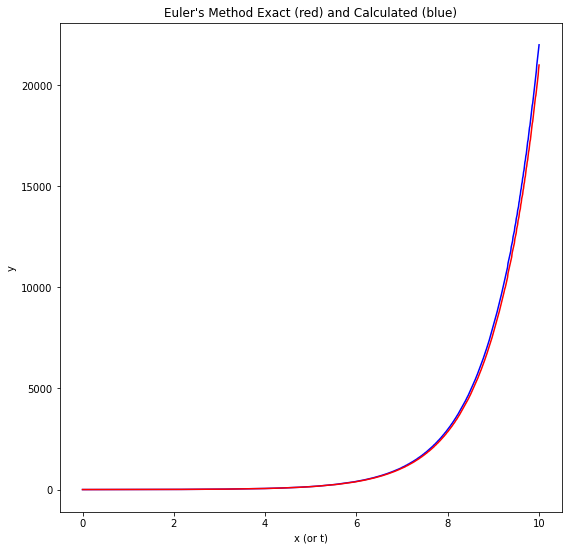

In [35]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Euler\'s Method Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

[5](#5) NRPy+ "Solving the Scalar Wave Equation"

[6](#6) https://www.dataquest.io/blog/read-file-python/

[7](#7) https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib

The following two graphs are just made with Excel. As should be clear in a moment, plotting them in python would not be particuarly illuminating. 

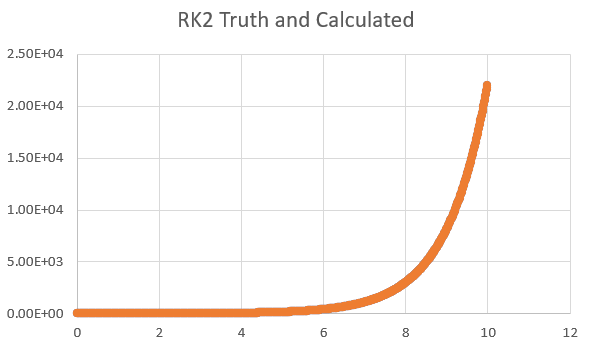

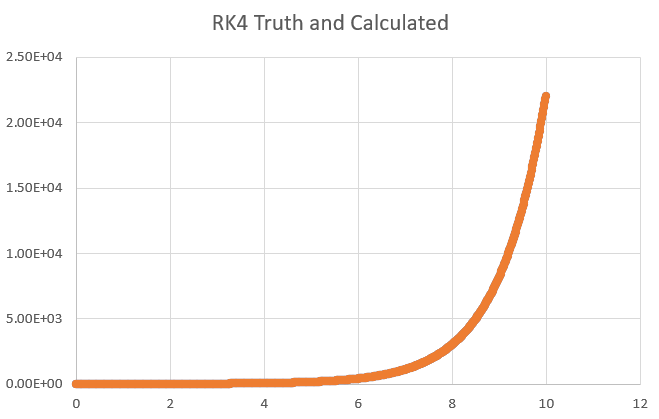

It is rather easy to note that these graphs are not helpful aside from saying "well it sure looks very accurate." The only time it's even noticable the difference between Truth and Calculated at this scale is on Euler's method, which just goes to show how accurate even a first-order approximation can be. So, instead, let's plot the Errors, it'll show us much more about how accurate the solution is at which locaitons. 

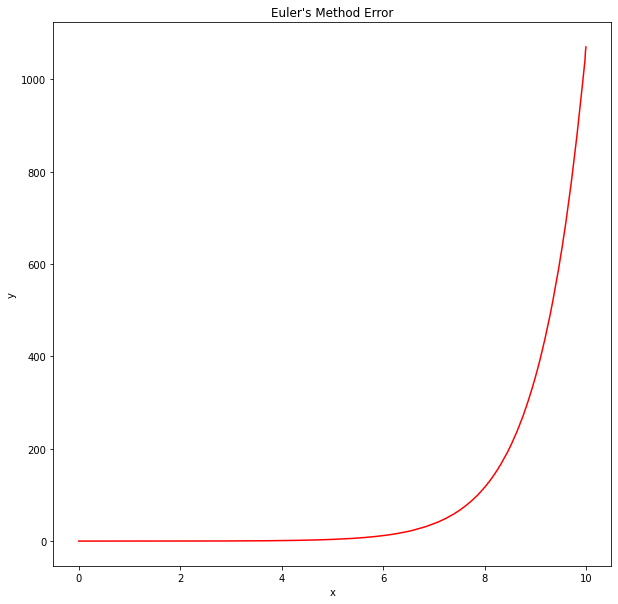

In [2]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Euler\'s Method Error')
ax.plot(positionList, errorList, color='r')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

The shape of the other methods is virtually identical in all except for amplitude.

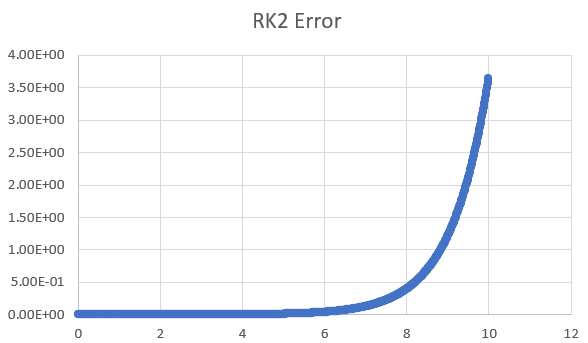

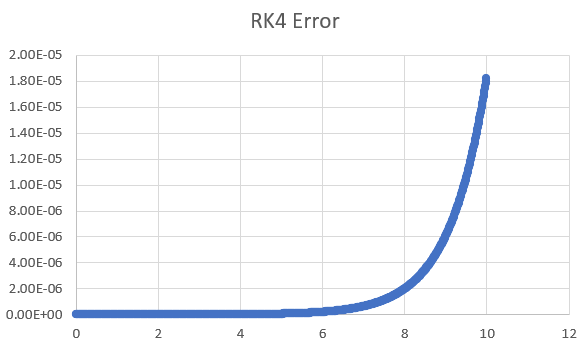

One may note the absolutely identical shape of these graphs, but that their *scale* is different. Each method is orders of magnitude different from each other in terms of error, even if the error behaves the same in each of them. RK4 is leagues better than the other two. If we compare to the actual true calculated value, Euler's method is off by 1/10th by the time we reach x=10, RK2 is off by 1/10,000th, and RK4 by 1/1,000,000,000th.

However, we have not done any adjusting of the `step` variable, which is the other paremeter of concern we have when error is involved. The program is not naturally suited to plot this, as it generally only runs through with one step size and keeps it throughout the program, but we could just run it multiple times and stitch the data together. Or, alternatively, make a NEW program based on the old one that iterates over `step` rather than increasing x. 

In our case, we chose a quick and dirty solution: alter the functions to vary `step` when iterating through. Here's the adjusted for loop for Euler's method.

```
for (int i = 1; i < SIZE+1; i++){
        
                y2 = y1 + step*i*diffyQEval(bound,y1);
        
                yTruth2 = knownQEval(bound+step*i);
                yError = (yTruth2 - y2);

                fprintf(fp,"Position:\t%f\tTruth:\t%10.9e\tCalculated:\t%10.9e\tError:\t%10.9e\t\n",bound+i*step,yTruth2, y2, yError);
            }
```

Which we can use to get initial error vs step size. Naturally we only tested step sizes up to 1, but we started at 0.0001. We chose the RK4 method for python plotting since it is the most interesting. 

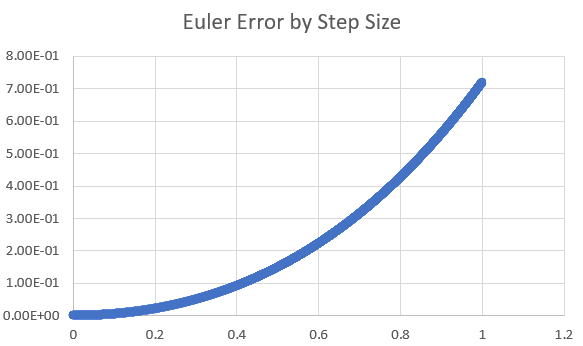

The error term for Euler's Method should be quadratic. A simple test for this is to see a place that has half step size should have fourth the size, which is roughly what we see on this graph comparing 1 to 0.5. 

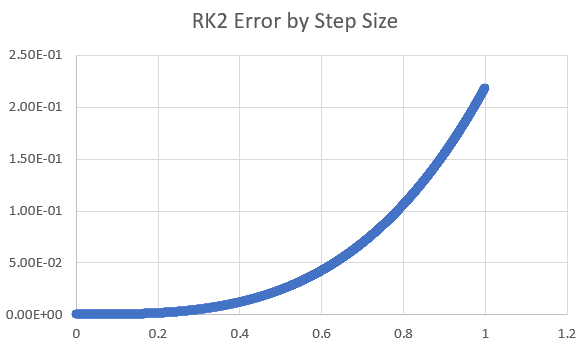

This should be cubic. This means a term at 1/2 a step size should have 1/8th the error, which is roughly what we see here from step 1 to step 0.5.

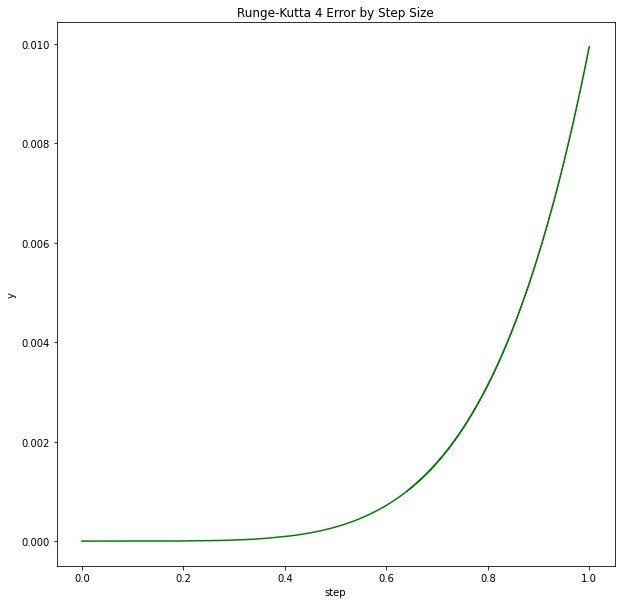

In [3]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData2.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('step')
ax.set_ylabel('y')
ax.set_title('Runge-Kutta 4 Error by Step Size')
ax.plot(positionList, errorList, color='g')
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(10,10)

This should be quintic. It does appear to be. Error is also significantly smaller than the other methods. 

It is often more illuminating to see a logarithmic plot of the error. While the order is not obvious from these plots, the types of errors we get closer to 0 are much easier to see.

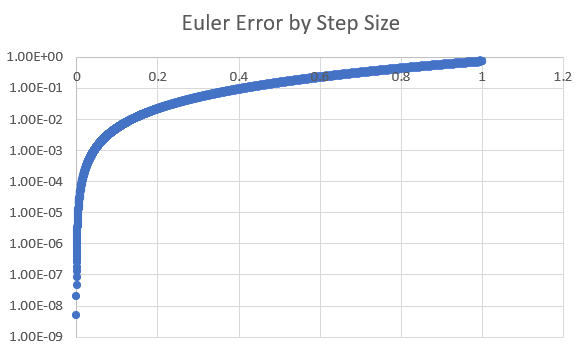

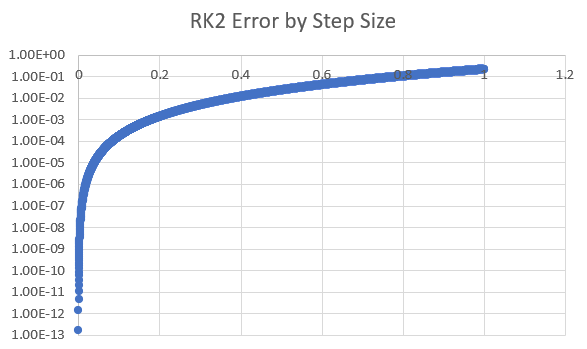

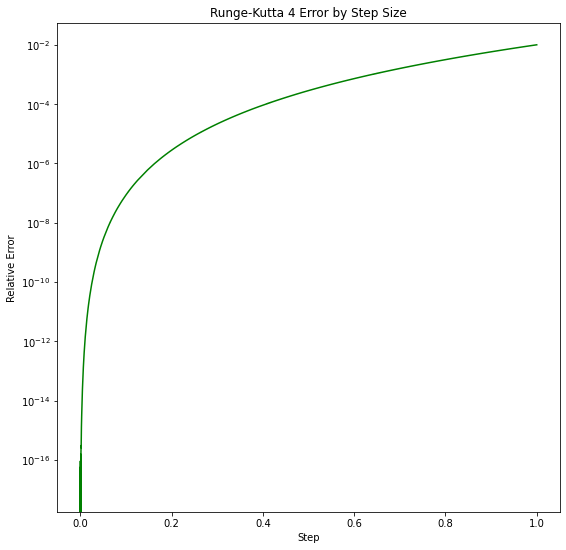

In [17]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData2.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[7]))

fig, ax = plt.subplots()
ax.set_xlabel('Step')
ax.set_ylabel('Error')
ax.set_title('Runge-Kutta 4 Error by Step Size')
ax.plot(positionList, errorList, color='g')
ax.set_yscale("log") #found in matplotlib's documentation.
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(9,9)


Note that all of these are Error values that are not scaled, which is why the RK4 error really does seem to go below the precision limit. We can scale the error, though by dividing by the True value at every point. 

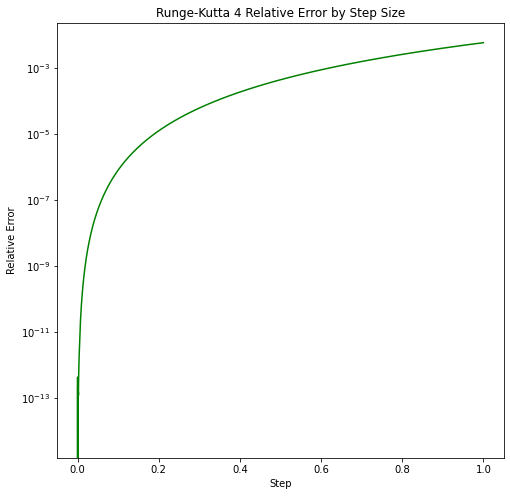

In [18]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
errorList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData2.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        errorList.append(float(row[13]))

fig, ax = plt.subplots()
ax.set_xlabel('Step')
ax.set_ylabel('Relative Error')
ax.set_title('Runge-Kutta 4 Relative Error by Step Size')
ax.plot(positionList, errorList, color='g')
ax.set_yscale("log") #found in matplotlib's documentation.
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying. 
fig.set_size_inches(8,8)

Which notably does approach the expected precision, 1e15.

Below we have a "Graph playground" which will be removed at some point.

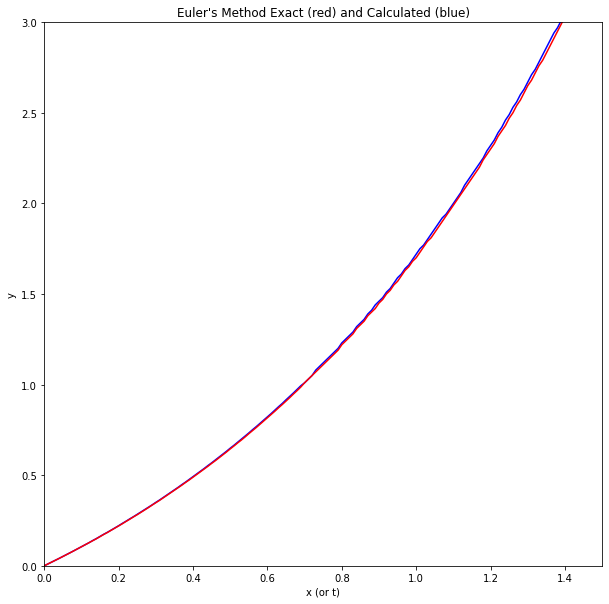

In [24]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('Euler\'s Method Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0,1.5)
plt.ylim(0,3)

fig.set_size_inches(10,10)
fig.title = 'Title'

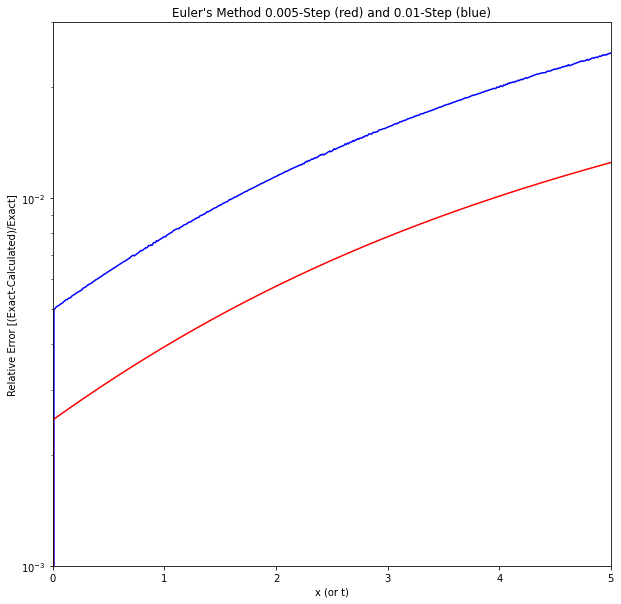

In [79]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(float(row[7])/(float(row[3])+0.000000000000001))
        
with open('ODEDatafile3.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(float(row[7])/(float(row[3])+0.000000000000001))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('Euler\'s Method 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='b')
ax.plot(positionList2, error2List, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0,5)
ax.set_yscale("log") #found in matplotlib's documentation.
plt.ylim(0.001,0.03)
fig.set_size_inches(10,10)
fig.title = 'Title'

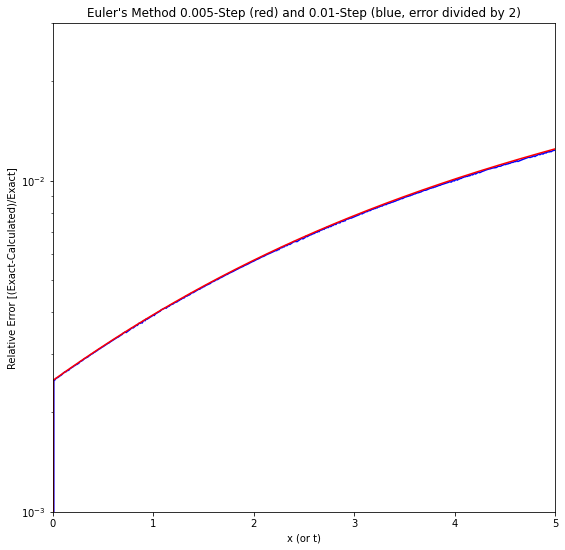

In [86]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('ODESolverData1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append((float(row[7])/(float(row[3])+0.000000000000001))/2.0)
        
with open('ODEDatafile3.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(float(row[7])/(float(row[3])+0.000000000000001))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('Euler\'s Method 0.005-Step (red) and 0.01-Step (blue, error divided by 2)')
ax.plot(positionList, error1List, color='b')
ax.plot(positionList2, error2List, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0,5)
ax.set_yscale("log") #found in matplotlib's documentation.
plt.ylim(0.001,0.03)
fig.set_size_inches(9,9)
fig.title = 'Title'

Below are RK4 graphs and code for them. 

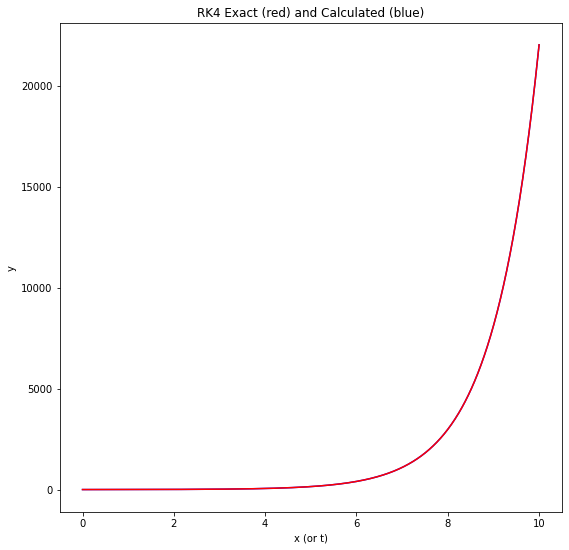

In [90]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('RK4-1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('RK4 Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
fig.set_size_inches(9,9)
fig.title = 'Title'

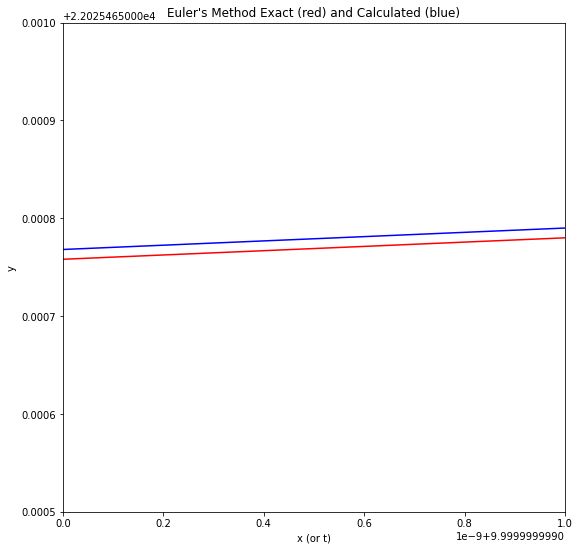

In [77]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
truthList = []
calculatedList = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('RK4-1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        truthList.append(float(row[3]))
        calculatedList.append(float(row[5]))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('y')
ax.set_title('RK4 Exact (red) and Calculated (blue)')
ax.plot(positionList, truthList, color='b')
ax.plot(positionList, calculatedList, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(9.999999999,10)
plt.ylim(22025.4655,22025.466)

fig.set_size_inches(9,9)
fig.title = 'Title'

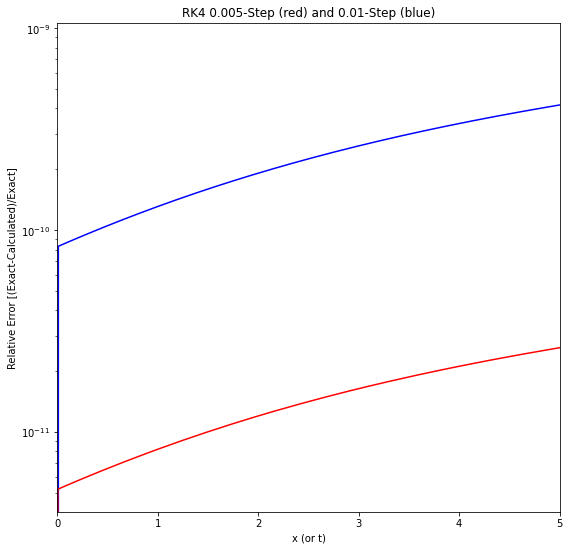

In [91]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('RK4-1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append(float(row[7])/(float(row[3])+0.000000000000001))
        
with open('RK4-2.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(float(row[7])/(float(row[3])+0.000000000000001))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('RK4 0.005-Step (red) and 0.01-Step (blue)')
ax.plot(positionList, error1List, color='b')
ax.plot(positionList2, error2List, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0,5)
ax.set_yscale("log") #found in matplotlib's documentation.
# plt.ylim(0.001,0.03)
fig.set_size_inches(9,9)
fig.title = 'Title'

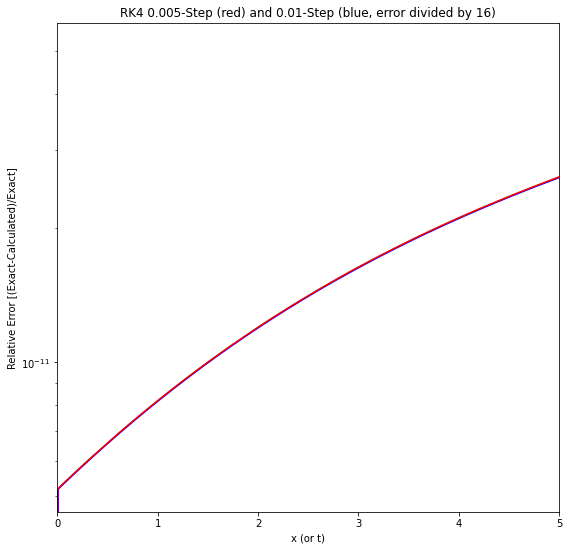

In [92]:
#plotting code adapated from NRPy "Solving the Scalar Wave Equation"
import matplotlib.pyplot as plt

positionList = []
positionList2 = []
error1List = []
error2List = []
i = 0

# csv file interface from https://www.dataquest.io/blog/read-file-python/
import csv
with open('RK4-1.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList.append(float(row[1]))
        error1List.append((float(row[7])/(float(row[3])+0.000000000000001))/16.0)
        
with open('RK4-2.csv') as f: # this file was added manually to the folder, it was created from an Excel document. 
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        positionList2.append(float(row[1]))
        error2List.append(float(row[7])/(float(row[3])+0.000000000000001))

fig, ax = plt.subplots()
ax.set_xlabel('x (or t)')
ax.set_ylabel('Relative Error [(Exact-Calculated)/Exact]')
ax.set_title('RK4 0.005-Step (red) and 0.01-Step (blue, error divided by 16)')
ax.plot(positionList, error1List, color='b')
ax.plot(positionList2, error2List, color='r') 
# https://stackoverflow.com/questions/332289/how-do-i-change-the-size-of-figures-drawn-with-matplotlib 
# setting size was annoying.
plt.xlim(0,5)
ax.set_yscale("log") #found in matplotlib's documentation.
# plt.ylim(0.001,0.03)
fig.set_size_inches(9,9)

<a id='S4'></a>

# Step 4: Conclusion \[Back to [top](#toc)\]
$$\label{S4}$$

### So, what have we learned today?

Now that we have arrived at the end, what now? Well, we are reasonably confident that all the methods are coded correctly and that the solver is accurate. We have also found holes where there will be some imperfections in the code, but have deduced that they are of minimal concern to the overall functionality of the method. 

Normally at this point we would go into how a user would make use of the code, but this is currently just a preliminary code that doesn't have all its features, so in the end this is more of a placeholder. More detailed instructions on use and warnings will go here eventually. 

In summary, the code works and is almost ready to move on to the next stage: multiple ODEs solved at once as a system. But before we do that, there is another mode of functionality: allowing the code to be passed NRPy's Butcher Tables in order to use *any* possible Runge-Kutta-like method. 

<a id='S5'></a>

# Step 5: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{S5}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-NRPyPlus_10_Minute_Overview.pdf](Tutorial-NRPyPlus_10_Minute_Overview.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [6]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-NRPyPlus_10_Minute_Overview")

ModuleNotFoundError: No module named 'cmdline_helper'